In [ ]:
import pandas as pd
import numpy as np
import io
from google.colab import files
from google.colab import drive
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from scipy.linalg import sqrtm
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
uploaded_austin = files.upload()

In [ ]:
austin_raw = pd.read_csv(io.BytesIO(uploaded_austin['TA Austin - cleaned.csv']))
print('The size of raw Austin.csv file is', austin_raw.shape)

In [ ]:
uploaded_napa = files.upload()

In [ ]:
napa_raw = pd.read_csv(io.BytesIO(uploaded_napa['TA Napa - raw.csv']), usecols = [2,3,5,6,7])
print('The size of raw Napa.csv file is', napa_raw.shape)

In [ ]:
uploaded_sonoma = files.upload()

In [ ]:
sonoma_raw = pd.read_csv(io.BytesIO(uploaded_sonoma['TA Sonoma - raw.csv']), usecols = [2,3,5,6,7])
print('The size of raw Sonoma.csv file is', sonoma_raw.shape)

In [ ]:
def clean(data, raw):
  data = data.copy()
  if raw:
    data['link-href'] = data['link-href'].map(lambda x: "-".join(x.split("-", 3)[1:3]))
    data['user-href'] = data['user-href'].map(lambda x: x.rsplit('/')[-1])
    data['rating'] = data['rating'].map(lambda x: x.lstrip('<span class="ui_bubble_rating bubble_').rstrip('0"></span>')).astype(int)
    data['date'] = data['date'].map(lambda x: " ".join(x.rsplit(" ", 2)[-2::]))
    data.columns = ['activity', 'activityID','userID','rating','date']
    data = data[-data['userID'].map(lambda x: x.startswith('Attraction'))]
    data = data[data['date'].map(lambda x: len(x.split(' ')[1]) == 4)]
    print('After transform to cleaned data and delete the whole row with unfitted template, the size is', data.shape)
  else:
    data['rating'] = data['rating'] / 10


  # drop duplicate rows
  if (data.shape == data.drop_duplicates().shape):
    print('No duplicate rows in this dataset. The size of the csv file is', data.shape)
  else: 
    duplicates = data[data.duplicated(keep = False)]
    duplicates = (duplicates.groupby(duplicates.columns.tolist()).apply(lambda x: tuple(x.index)).reset_index(name='idx'))
    data = data.drop_duplicates()
    print(duplicates.shape[0], 'rows are duplicated in this dataset. Size after remove them is', data.shape)
  

  # Keep the most recent rating
  latest = data.copy()
  latest.date = pd.to_datetime(latest.date)
  latest = latest.sort_values(by = 'date', ascending = False).drop_duplicates(subset=['activity','activityID','userID'], keep = 'first').sort_values('activity')
  print("Only keep the most recent rating for users, the size of data is :",latest.shape)


  return data, latest

In [ ]:
print('-------------------------- Austin --------------------------')
austin, latest_austin = clean(austin_raw, False)

In [ ]:
print('-------------------------- Napa --------------------------')
napa, latest_napa = clean(napa_raw, True)
print('-------------------------- Sonoma --------------------------')
sonoma, latest_sonoma = clean(sonoma_raw, True)

-------------------------- Napa --------------------------
After transform to cleaned data and delete the whole row with unfitted template, the size is (51422, 5)
1619 rows are duplicated in this dataset. Size after remove them is (49803, 5)
Only keep the most recent rating for users, the size of data is : (49121, 5)
-------------------------- Sonoma --------------------------
After transform to cleaned data and delete the whole row with unfitted template, the size is (41880, 5)
1952 rows are duplicated in this dataset. Size after remove them is (39925, 5)
Only keep the most recent rating for users, the size of data is : (39202, 5)


#def trans1 - combine dataset & X year & matrix

In [ ]:
def trans1(data1, des1, data2, des2, year):

  # combine data
  data1['destination'] = des1
  data2['destination'] = des2
  combine = data1.append(data2)
  print('After add new data, we have', combine.shape, 'record.')


  # drop duplicate rows
  if (combine.shape == combine.drop_duplicates().shape):
    print('No duplicate rows in this dataset. The size of the csv file is', combine.shape)
  else: 
    duplicates = combine[combine.duplicated(keep = False)]
    duplicates = (duplicates.groupby(duplicates.columns.tolist()).apply(lambda x: tuple(x.index)).reset_index(name='idx'))
    combine = combine.drop_duplicates()
    print(duplicates.shape[0], 'rows are duplicated in this dataset. Size after remove them is', combine.shape)
  

  # Keep the most recent rating
  combine.date = pd.to_datetime(combine.date)
  combine = combine.sort_values(by = 'date', ascending = False).drop_duplicates(subset=['activity','activityID','userID'], keep = 'first').sort_values('activity')
  print("Only keep the most recent rating for users, the size of data is :",combine.shape)


  # X year
  if year != 0:
    combine = combine[combine['date'].map(lambda x: int(str(x).split('-')[0]) >= year)]
    print('Data after year', year, 'has', combine.shape, 'record.')

  # trans to matrix
  df_m = pd.pivot_table(combine, index=["destination","activityID"], values=["rating"], columns=["userID"])
  df_m.columns = df_m.columns.droplevel(0)
  df_m = df_m.rename_axis(None, axis=1)
  print('Reshape to matrix with size: ', df_m.shape, ', which contains', df_m.shape[0]*df_m.shape[1], 'cells.')
  print('% filled is', df_m.count().sum() / (df_m.shape[0]*df_m.shape[1]))
  print('Avg ratings per user: ', df_m.count().sum()/df_m.shape[1])
  print('# users with only 1 rating: ', np.sum(df_m.count(axis = 0) == 1))
  print('# products with only 1 rating: ', np.sum(df_m.count(axis = 1) == 1))

  # top 5 user
  top5 = pd.DataFrame({'# of ratings': df_m.count(axis = 0)}).sort_values('# of ratings', ascending = False).head(5)
  top5["col_index"] = top5.index.map(lambda x: df_m.columns.get_loc(x)).values
  print('Top 5 users are: \n', top5)
  return combine, df_m


In [ ]:
df_c,m_c = trans1(latest_napa, 'napa', latest_sonoma, 'sonoma', 0)

After add new data, we have (88323, 6) record.
No duplicate rows in this dataset. The size of the csv file is (88323, 6)
Only keep the most recent rating for users, the size of data is : (88323, 6)
Reshape to matrix with size:  (1019, 49431) , which contains 50370189 cells.
% filled is 0.001753477637338228
Avg ratings per user:  1.7867937124476543
# users with only 1 rating:  33805
# products with only 1 rating:  79
Top 5 users are: 
              # of ratings  col_index
mini                  155      41787
pfefmeister            74      43601
BoulderNut             53       8101
moviegal226            48      42154
karansimoni            46      38281


# SVD


In [ ]:
!pip install scikit-surprise

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader, accuracy, Trainset, KNNBasic
from surprise import Trainset
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

# data transformation

Normalization, then turns into the data format that Surprise needs

In [ ]:
# scenario1 & 2
latest_austin['normal_rating'] = preprocessing.scale(latest_austin['rating'])
reader = Reader(rating_scale=(1, 5))
datafull = Dataset.load_from_df(latest_austin[['userID', 'activityID', 'normal_rating']], reader)

In [ ]:
# scenario3 - combine Napa & Sonoma
df_c['normal_rating'] = preprocessing.scale(df_c['rating'])
reader = Reader(rating_scale=(1, 5))
datafull = Dataset.load_from_df(df_c[['userID', 'activityID', 'normal_rating']], reader)

In [ ]:
# scenatio4 - delete user and item that has only one rating
df_u = df_c[df_c.groupby('userID').userID.transform(len) > 1]
df_p = df_u.groupby('activityID').filter(lambda x: len(x) > 1)
df_p['normal_rating'] = preprocessing.scale(df_p['rating'])
reader = Reader(rating_scale=(1, 5))
datafull = Dataset.load_from_df(df_p[['userID', 'activityID', 'normal_rating']], reader)

# Tune algorithm parameters

{'rmse': 0.2413911742278266, 'mae': 0.13421886178909817}
{'rmse': {'n_factors': 2}, 'mae': {'n_factors': 1}}


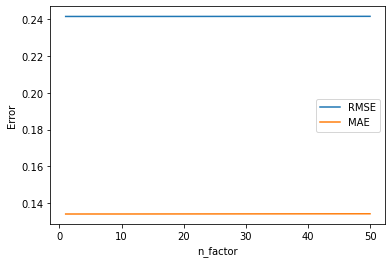

In [ ]:
# n_factor
factor_grid = {'n_factors': [1,2,3,5,10,20,50]}
nf = GridSearchCV(SVD, factor_grid, measures=['rmse', 'mae'], cv = 3)
nf.fit(datafull)
print(nf.best_score)
print(nf.best_params)
plt.plot(nf.cv_results['param_n_factors'], nf.cv_results['mean_test_rmse'], label = "RMSE") 
plt.plot(nf.cv_results['param_n_factors'], nf.cv_results['mean_test_mae'], label = "MAE") 
plt.xlabel('n_factor')
plt.ylabel('Error')
plt.legend() 

In [ ]:
pd.DataFrame({'n_factors': nf.cv_results['param_n_factors'],
             'mean_test_rmse': nf.cv_results['mean_test_rmse'],
             'mean_test_mae': nf.cv_results['mean_test_mae']})

,n_factors,mean_test_rmse,mean_test_mae
0,1,0.241391,0.134219
1,2,0.241391,0.134220
2,3,0.241392,0.134222
3,5,0.241392,0.134229
4,10,0.241393,0.134229
5,20,0.241402,0.134258
6,50,0.241456,0.134352


{'rmse': 0.8383382445950819, 'mae': 0.6324374891579047}
{'rmse': {'lr_all': 0.002}, 'mae': {'lr_all': 0.01}}


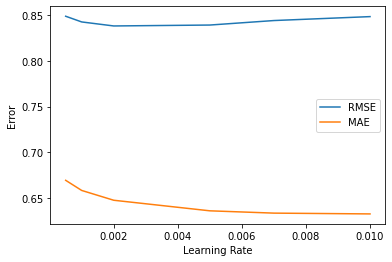

In [ ]:
# learning rate
lr_grid = {'lr_all': [0.0005, 0.001, 0.002, 0.005, 0.007, 0.01]}
lr = GridSearchCV(SVD, lr_grid, measures=['rmse', 'mae'], cv = 3)
lr.fit(datafull)
print(lr.best_score)
print(lr.best_params)
plt.plot(lr.cv_results['param_lr_all'], lr.cv_results['mean_test_rmse'], label = "RMSE") 
plt.plot(lr.cv_results['param_lr_all'], lr.cv_results['mean_test_mae'], label = "MAE") 
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.legend()
plt.show() 

{'rmse': 0.8329822320783834, 'mae': 0.634408585884427}
{'rmse': {'reg_all': 0.1}, 'mae': {'reg_all': 0.07}}


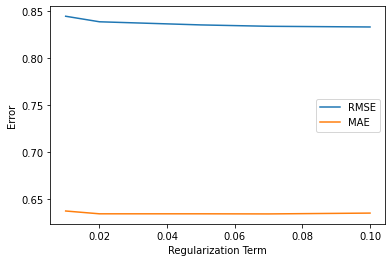

In [ ]:
# regularization 
reg_grid = {'reg_all': [0.01, 0.02, 0.05, 0.07, 0.1]}
reg = GridSearchCV(SVD, reg_grid, measures=['rmse', 'mae'], cv = 3)
reg.fit(datafull)
print(reg.best_score)
print(reg.best_params)
plt.plot(reg.cv_results['param_reg_all'], reg.cv_results['mean_test_rmse'], label = "RMSE") 
plt.plot(reg.cv_results['param_reg_all'], reg.cv_results['mean_test_mae'], label = "MAE") 
plt.xlabel('Regularization Term')
plt.ylabel('Error')
plt.legend()
plt.show()

Try different combinations of the parameter and return the best one.

In [ ]:
param_grid = {'n_factors': [1, 2], 'n_epochs': [50,100], 'lr_all': [0.002, 0.01], 'reg_all': [0.07, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv = 3)
gs.fit(datafull)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
# Build an algorithm, and train it.
algo = gs.best_estimator['rmse']

0.8306251453429847
{'n_factors': 1, 'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.07}


# scenario1

In [ ]:
# train set 90%, test set 10%
trainset90, testset10 = train_test_split(datafull, test_size=.1)
predictions10 = algo.fit(trainset90).test(testset10)
print('MSE for train set 90%, test set 10%:', accuracy.rmse(predictions10) **2)

In [ ]:
#train set 80%, test set 20%
trainset80, testset20 = train_test_split(datafull, test_size=.2)
predictions20 = algo.fit(trainset80).test(testset20)
print('MSE for train set 80%, test set 20%:', accuracy.rmse(predictions20) **2)

RMSE: 0.7535
MSE for train set 80%, test set 20%: 0.5678026070554254


In [ ]:
#train set 75%, test set 25%
trainset75, testset25 = train_test_split(datafull, test_size=.2)
predictions25 = algo.fit(trainset75).test(testset25)
print('MSE for train set 75%, test set 25%:', accuracy.rmse(predictions25) **2)

RMSE: 0.7540
MSE for train set 80%, test set 20%: 0.5684488288369062


In [ ]:
# train set 67%, test set 33%
trainset67, testset33 = train_test_split(datafull, test_size=.5)
predictions33 = algo.fit(trainset67).test(testset33)
print('MSE for train set 67%, test set 33%:', accuracy.rmse(predictions33) **2)

RMSE: 0.7577
MSE for train set 67%, test set 33%: 0.5741023901110516


In [ ]:
# train set 10%, test set 90%
trainset10, testset90 = train_test_split(datafull, test_size=.9)
predictions90 = algo.fit(trainset10).test(testset90)
print('MSE for train set 10%, test set 90%:', accuracy.rmse(predictions90) **2)

RMSE: 0.7799
MSE for train set 10%, test set 90%: 0.6082579907033442


# scenario2

In [ ]:
def single_user_oneplace(data, uid):
  temp = data.loc[data['userID'] == uid]
  # test data
  test = temp.iloc[5:,[2,1,5]].to_records(index = False).tolist()
  # train data
  train = data.drop(labels=temp.index.to_list()[5:])
  train = Dataset.load_from_df(train[['userID', 'activityID', 'normal_rating']], reader)
  # prediction
  pred = algo.fit(train.build_full_trainset()).test(test)
  print(accuracy.rmse(pred) **2)
  return train, test, pred

In [ ]:
train_jack, test_jack, pred_jack = single_user_oneplace(latest_austin, 'mljack')

RMSE: 0.8659
0.7497911175804233


In [ ]:
train_p74, test_p74, pred_p74 = single_user_oneplace(latest_austin, 'P7464TCjoelm')

RMSE: 0.2954
0.0872854929761815


In [ ]:
train_pnk, test_pnk, pred_pnk = single_user_oneplace(latest_austin, 'pnkgirl27')

RMSE: 1.0900
1.1881594429848423


In [ ]:
train_tony, test_tony, pred_tony = single_user_oneplace(latest_austin, 'tonyh120')

RMSE: 0.5366
0.287953582325876


In [ ]:
train_501, test_501, pred_501 = single_user_oneplace(latest_austin, '501glorial')

RMSE: 0.4295
0.1844659467747477


In [ ]:
train_mini, test_mini, pred_mini = single_user_oneplace(latest_napa, 'mini')

RMSE: 0.6308
0.3979012481086628


In [ ]:
train_mini, test_mini, pred_mini = single_user_oneplace(latest_napa, 'moviegal226')

RMSE: 1.1638
1.354453253822309


In [ ]:
train_kar, test_kar, pred_kar = single_user_oneplace(latest_napa, 'karansimoni') 

RMSE: 0.6908
0.4772541122965351


In [ ]:
train_kwa, test_kwa, pred_kwa = single_user_oneplace(latest_napa, 'kwagmeister') 

RMSE: 0.3772
0.1422617704574435


# scenario3

In [ ]:
# for scenario3 & 4
def single_user(clean_data, uid, des):
  data = clean_data.copy()
  # test set
  test = data[(data['userID'] == uid) & (data['destination'] == des)].iloc[:,[2,1,6]].to_records(index = False).tolist()
  # train set
  data = data[-((data['userID'] == uid) & (data['destination'] == des))]
  data = Dataset.load_from_df(data[['userID', 'activityID', 'normal_rating']], reader)

  return data, test

In [ ]:
train, test = single_user(df_p, 'mini', 'sonoma')

In [ ]:
train2, test2 = single_user(df_p, 'pfefmeister', 'sonoma')

In [ ]:
# 'mini'
pred_mini = algo.fit(train.build_full_trainset()).test(test)
accuracy.rmse(pred_mini) ** 2

RMSE: 0.5595


0.31303696521976593

In [ ]:
# 'pfefmeister'
pred_pf = algo.fit(train2.build_full_trainset()).test(test2)
accuracy.rmse(pred_pf) ** 2

RMSE: 0.4631


0.2144455980374478